In [1]:
%cd /Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/

/Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt


In [2]:
import tensorflow as tf
path = '/Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/'
block_h = 32
block_w = 32
Model = tf.keras.models.load_model(path + 'Outputs/' + 'Model_Case_1_1.h5')

/Users/vitthal/miniforge3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-09-05 17:21:56.995088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-05 17:21:56.995166: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [3]:
def window(p,q,layer,flair_data):
    W = flair_data[p:p+32,q:q+32,layer]
    return W

def ML_function(Windows,layer):
    count = 0
    X = np.array(Windows).reshape(-1, block_h, block_w, 1)
    predicted_classes = np.argmax(Model(X), axis=1)
    for val in predicted_classes:
        if (val == 1):
            count = count + 1            
    #print(count)
    return count
    
def fun(a,b,layer,flair_data):
    if(a<0 or a>239 or b<0 or b>239):
        print("invalid point")
    else:
        Windows = []
        for x in range (a-31,a+1):
            for y in range (b-31,b+1):
                Windows.append(window(x,y,layer,flair_data))
        count_1 = ML_function(Windows,layer)
    return (count_1/1024)

In [4]:
def Generate_Weighted_Matrix():
    import pickle
    taskdir= os.listdir(Task_data)
    if '.DS_Store' in taskdir:
        taskdir.remove('.DS_Store')
    for Type in taskdir:
        print(Type)
        Type_Path = os.path.join(Task_data, Type + '/')
        typepathdir=os.listdir(Type_Path)
        if '.DS_Store' in typepathdir:
            typepathdir.remove('.DS_Store')
        for patient in typepathdir:
            print(patient)
            Patient_Path = os.path.join(Type_Path, patient + '/')
            os.chdir(Patient_Path)
            flair = nib.load('{}_flair.nii.gz'.format(patient))
            flair_data = flair.get_fdata() #Converting nii to 3d np array
            
            for l in range (0, flair_data.shape[2]): #Scale data between 0 & 255
                if (flair_data[:,:,l].max() == 0):
                    continue
                else:
                    flair_data[:,:,l] *= (255.0/flair_data[:,:,l].max())
                
            seg_mask = nib.load('{}_seg.nii.gz'.format(patient))
            seg_mask_data = seg_mask.get_fdata() #Converting nii to 3d np array

            #Extracting only those layers from mask which have non zero values
            z = np.any(seg_mask_data, axis=(0, 1))
            nonzero_layers = np.nonzero(z)
            nonzero_layer_indices = nonzero_layers[0]
            num_layers = nonzero_layer_indices.size
            #print(num_layers)
            arr = np.zeros((240,240,num_layers))
            layer_num = 0

            # Select the layer with maximum pixels

            
            #Finding indices of cancer pixels using mask data
            for layer in nonzero_layer_indices:
                indices = np.transpose(np.nonzero(seg_mask_data[:,:,layer]))
                #print(indices, layer)
                for [a,b] in indices:
                    arr[a,b,layer_num] = fun(a,b,layer,flair_data)
                layer_num = layer_num + 1
                
            #print(np.count_nonzero(np.any(arr, axis=(0, 1))))
            
            #Calculating weighted average                
            Weighted_matrix = np.zeros((240,240))
            for x in range (0,240):
                for y in range (0,240):
                    Sum = 0
                    num_terms = 0
                    for slice_num in range (0,num_layers):
                        if(arr[x][y][slice_num] != 0):
                            Sum = Sum + arr[x][y][slice_num]
                            num_terms = num_terms + 1
                    if(num_terms != 0):
                        Weighted_matrix[x][y] = Sum/num_terms
            print(Weighted_matrix.shape)

            #Storing Wiegted Average Matrix of the patient
            pickle_out = open(Patient_Path + '/W_M_{}.pickle'.format(patient), 'wb')
            pickle.dump(Weighted_matrix, pickle_out)
            pickle_out.close()
          

In [6]:
# All Function Calls
import os
import numpy as np
import nibabel as nib

PATH = path + 'Data/'
Task_data = PATH + 'Task_data/'

# Function Call --> Generate Tumor Images of Patients
Generate_Weighted_Matrix()

MGMT_positive
BraTS2021_00000
(240, 240)
MGMT_negative
BraTS2021_00003
(240, 240)


In [11]:
import pickle
pickle_in_negative = open(
    '/Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/Task_data/MGMT_negative/BraTS2021_00003/W_M_BraTS2021_00003.pickle', 'rb')
W_M_Negative_3 = pickle.load(pickle_in_negative)

In [12]:
print(np.count_nonzero(W_M_Negative_3))
print(W_M_Negative_3)
print(W_M_Negative_3.shape)

2850
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(240, 240)


In [13]:
pickle_in_positive = open(
    '/Users/vitthal/Documents/Research/DataScience/MedicalResearch/mgmt/Data/Task_data/MGMT_positive/BraTS2021_00000/W_M_BraTS2021_00000.pickle', 'rb')
W_M_Positive_0 = pickle.load(pickle_in_positive)

In [14]:
print(np.count_nonzero(W_M_Positive_0))
print(W_M_Positive_0)
print(W_M_Positive_0.shape)

2347
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(240, 240)


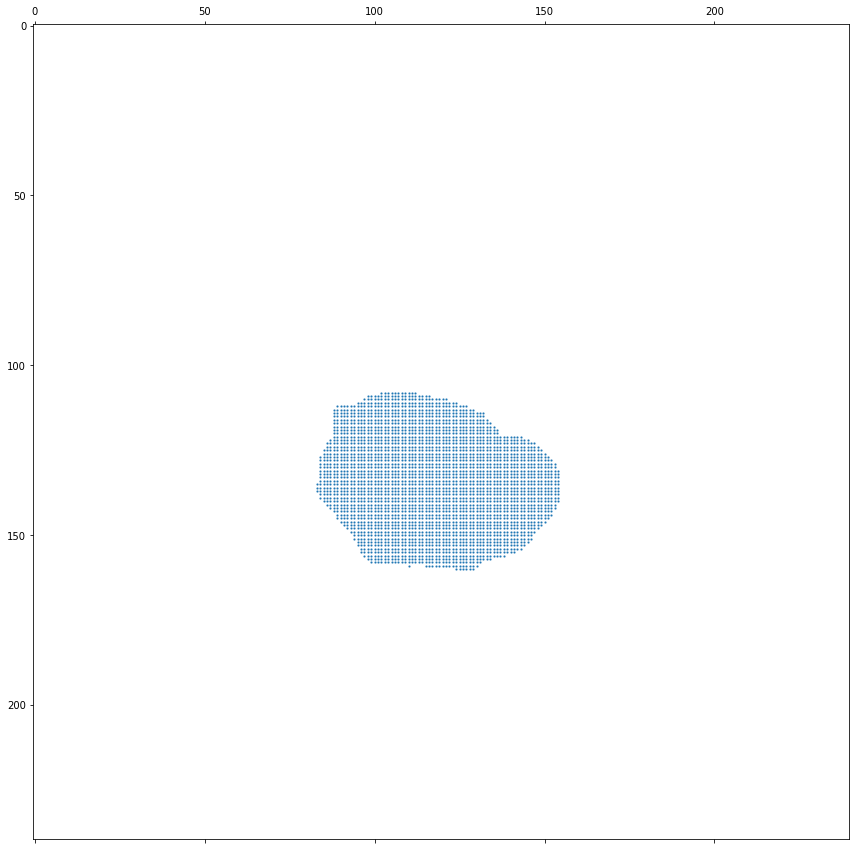

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.spy(W_M_Negative_3, markersize=1)

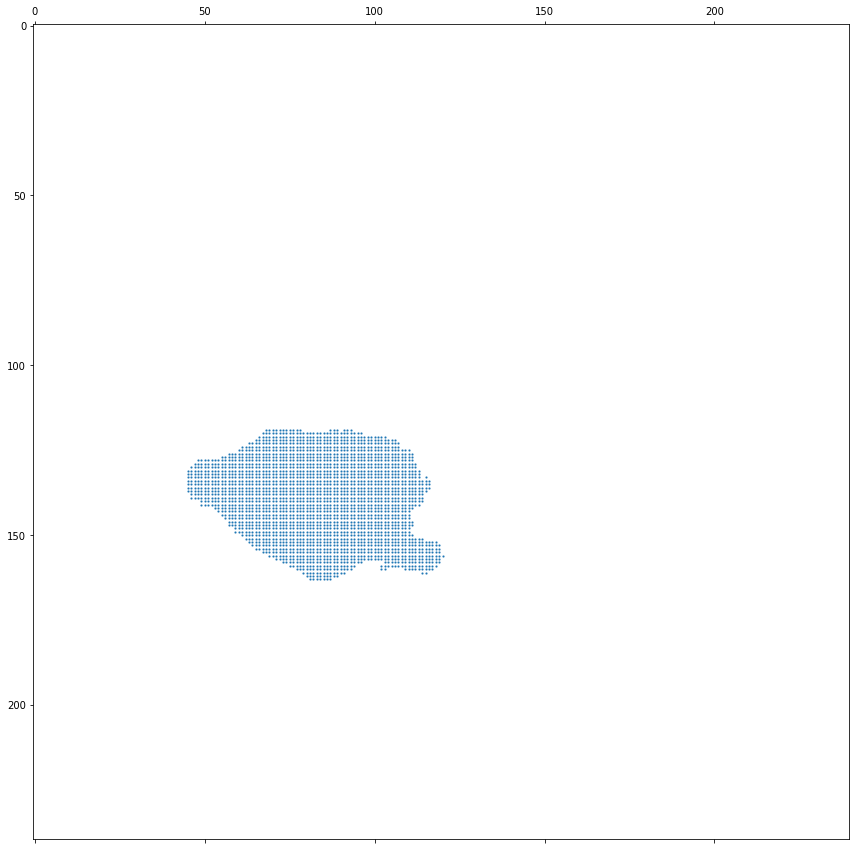

In [16]:
plt.figure(figsize=(15, 15))
plt.spy(W_M_Positive_0, markersize=1)